# Usage: scenario analysis
This is a quick tour of CovsirPhy. Details scenario analysis will be explained.
"Scenario analysis" means that we calculate the number of cases in the future phases with some sets of ODE parameter values. With this analysis, we can estimate the impact of our activities against the outbreak on the number of cases.

### Preparation
Prepare the packages.

In [1]:
# Standard users
# !pip install covsirphy

In [2]:
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [3]:
import covsirphy as cs
cs.__version__

'2.15.0'

### Dataset preparation
Download the datasets to "input" direcotry and load them.  
Please refer to [Usage: datasets](https://lisphilar.github.io/covid19-sir/usage_dataset.html) for the details.

In [4]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt()

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/



Please set verbose=2 to see the detailed citation list.




Retrieving COVID-19 dataset in Japan from https://github.com/lisphilar/covid19-sir/data/japan


### Start scenario analysis
As an example, we will analysis the number of cases in Japan.

In [5]:
snl = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

In [6]:
# >= version 2.15.0 or the latest development version
# If you want to stop displaying figures when using interactive shell,
# snl.interactive = False
# For temporally, plese use snl.records(show_figure=False) etc.
# If you want save figures,
# snl.interactive = False
# and please use snl.records(filename="records.jpg") etc.

### Check records
Let's see the records at first. `Scenario.records()` method return the records as a pandas dataframe and show a line plot. Some kind of complement will be done for analysis, if necessary.

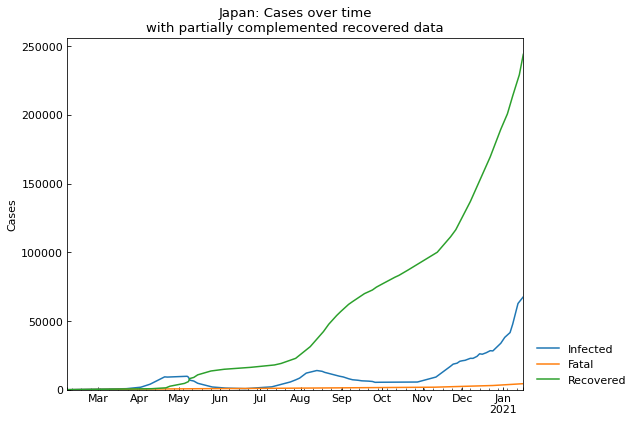

,Date,Infected,Fatal,Recovered
341,2021-01-12,62722,4094,225396
342,2021-01-13,64097,4145,229073
343,2021-01-14,64725,4233,233665
344,2021-01-15,66432,4315,238467
345,2021-01-16,67557,4380,243973


In [7]:
record_df = snl.records()
record_df.tail()

We can calculate the number of daily new cases with `Scenario.record_diff()` method.

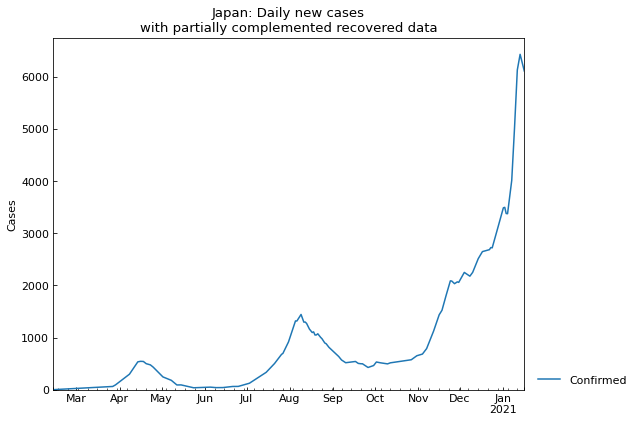

In [8]:
_ = snl.records_diff(variables=["Confirmed"], window=7)

`Scenario.show_complement()` method is useful to show the kinds of complement. The details of complement are explained in [Usage: datasets](https://lisphilar.github.io/covid19-sir/usage_dataset.html#The-number-of-cases-(JHU-style)) section.

In [9]:
complement_snl_df = snl.show_complement()
complement_snl_df.tail()

,Country,Province,Monotonic_confirmed,Monotonic_fatal,Monotonic_recovered,Full_recovered,Partial_recovered
0,Japan,-,False,False,True,False,True


### S-R trend analysis
S-R trend analysis finds the change points of SIR-derived ODE parameters. Details will be explained in [Usage (details: phases)](https://lisphilar.github.io/covid19-sir/usage_phases.html).

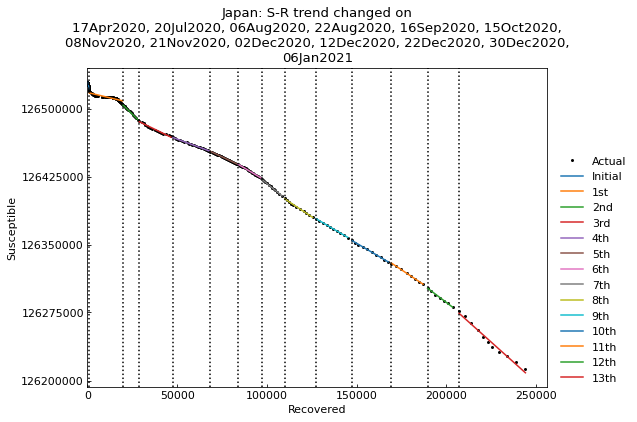

,Type,Start,End,Population
0th,Past,06Feb2020,16Apr2020,126529100
1st,Past,17Apr2020,19Jul2020,126529100
2nd,Past,20Jul2020,05Aug2020,126529100
3rd,Past,06Aug2020,21Aug2020,126529100
4th,Past,22Aug2020,15Sep2020,126529100
5th,Past,16Sep2020,14Oct2020,126529100
6th,Past,15Oct2020,07Nov2020,126529100
7th,Past,08Nov2020,20Nov2020,126529100
8th,Past,21Nov2020,01Dec2020,126529100
9th,Past,02Dec2020,11Dec2020,126529100


In [10]:
# Perform S-R trend analysis and set phases
snl.trend(set_phases=True)
snl.summary()

### Hyperparameter estimation of ODE models
Here, we will estimate the parameter values of SIR-derived models. As an example, we use SIR-F model. Details of models will be explained in [Usage (details: theoritical datasets)](https://lisphilar.github.io/covid19-sir/usage_theoretical.html).

In [11]:
# Estimate the parameter values of SIR-F model
snl.estimate(cs.SIRF)


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	12th phase (30Dec2020 - 05Jan2021): finished  317 trials in 0 min 10 sec


	 0th phase (08Nov2020 - 20Nov2020): finished  343 trials in 0 min 10 sec

	 6th phase (16Sep2020 - 14Oct2020): finished  340 trials in 0 min 10 sec

	 8th phase (12Dec2020 - 21Dec2020): finished  336 trials in 0 min 10 sec

	 3rd phase (22Dec2020 - 29Dec2020): finished  898 trials in 0 min 30 sec

	 4th phase (20Jul2020 - 05Aug2020): finished  621 trials in 0 min 20 sec

	 9th phase (22Aug2020 - 15Sep2020): finished  328 trials in 0 min 10 sec

	10th phase (02Dec2020 - 11Dec2020): finished  335 trials in 0 min 10 sec

	11th phase (21Nov2020 - 01Dec2020): finished 3337 trials in 3 min  0 sec

	 2nd phase (06Feb2020 - 16Apr2020): finished 3288 trials in 3 min  0 sec

	 7th phase (17Apr2020 - 19Jul2020): finished 3270 trials in 3 min  0 sec

	13th phase (06Jan2021 - 16Jan2021): finished 3308 trials in 3 min  0 sec

	 1st phase (06Aug2020 - 21Aug2020): finished 3434 trials in 3 min  0 sec

	 5th phase (15Oct2020 - 07Nov2020): finished 3438 trials in 3 min  0 sec

Completed optimization. Total: 6 min 22 sec


In [12]:
# Show the sumamry of parameter estimation
snl.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,1/alpha2 [day],1/beta [day],alpha1 [-],1/gamma [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,16Apr2020,126529100,SIR-F,4.64,0.019314,0.000191,0.052288,0.010854,720,2618,9,0.019,46,0.260938,3288,3 min 0 sec
1st,Past,17Apr2020,19Jul2020,126529100,SIR-F,0.56,0.071936,0.000406,0.016125,0.026429,720,1231,31,0.072,18,0.389551,3270,3 min 0 sec
2nd,Past,20Jul2020,05Aug2020,126529100,SIR-F,1.98,0.000590,0.000114,0.064282,0.032269,720,4389,7,0.001,15,0.021189,621,0 min 20 sec
3rd,Past,06Aug2020,21Aug2020,126529100,SIR-F,1.06,0.000483,0.000257,0.047723,0.044728,720,1948,10,0.000,11,0.039673,3434,3 min 0 sec
4th,Past,22Aug2020,15Sep2020,126529100,SIR-F,0.68,0.000350,0.000710,0.033912,0.049114,720,704,14,0.000,10,0.052936,328,0 min 10 sec
5th,Past,16Sep2020,14Oct2020,126529100,SIR-F,0.90,0.001151,0.000531,0.043952,0.048301,720,941,11,0.001,10,0.027704,340,0 min 10 sec
6th,Past,15Oct2020,07Nov2020,126529100,SIR-F,1.12,0.000250,0.000580,0.053020,0.046644,720,862,9,0.000,10,0.033157,3438,3 min 0 sec
7th,Past,08Nov2020,20Nov2020,126529100,SIR-F,1.59,0.000468,0.000551,0.071139,0.044182,720,906,7,0.000,11,0.012079,343,0 min 10 sec
8th,Past,21Nov2020,01Dec2020,126529100,SIR-F,1.41,0.000913,0.000408,0.056803,0.039791,720,1226,8,0.001,12,0.020991,3337,3 min 0 sec
9th,Past,02Dec2020,11Dec2020,126529100,SIR-F,1.18,0.000814,0.000843,0.052115,0.043444,720,593,9,0.001,11,0.008933,335,0 min 10 sec


### Accuracy of estimation

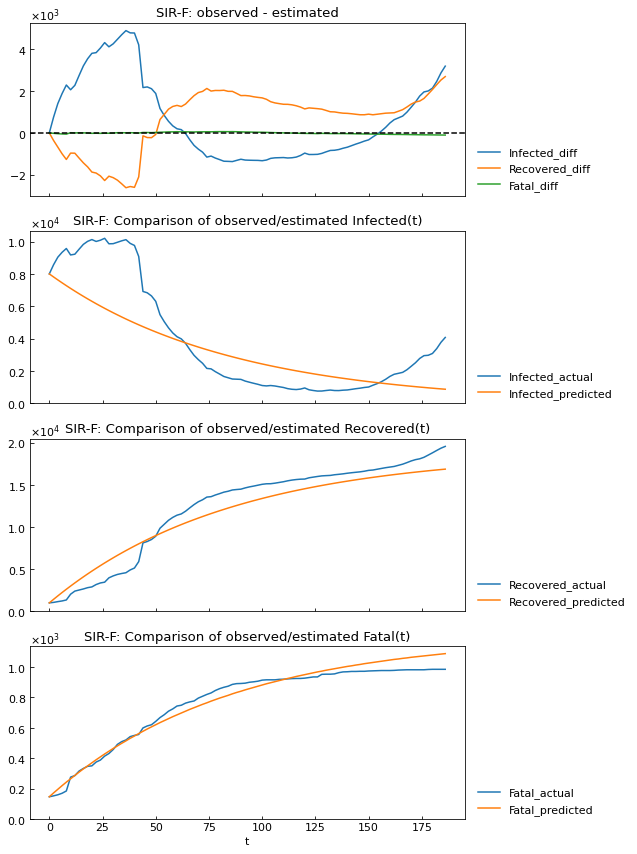

In [13]:
snl.estimate_accuracy(phase="1st")

### Get parameter value
We can get the parameter values of a phase using `Scenario.get()` method.

In [14]:
snl.get("Rt", phase="4th")

0.68

### Show parameter history
`Scenario.history()` method shows the trajectories of parameters (and the number of cases).

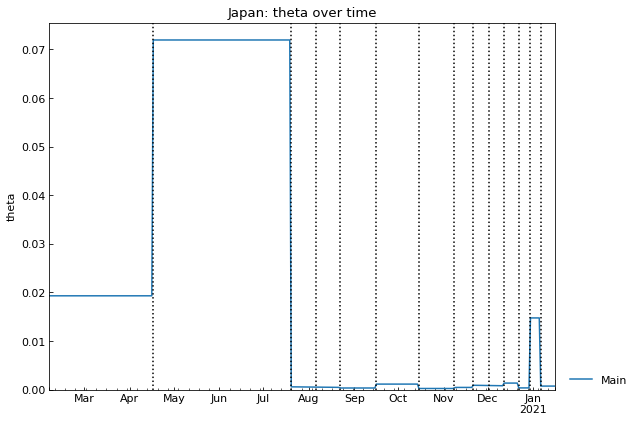

In [15]:
_ = snl.history(target="theta")

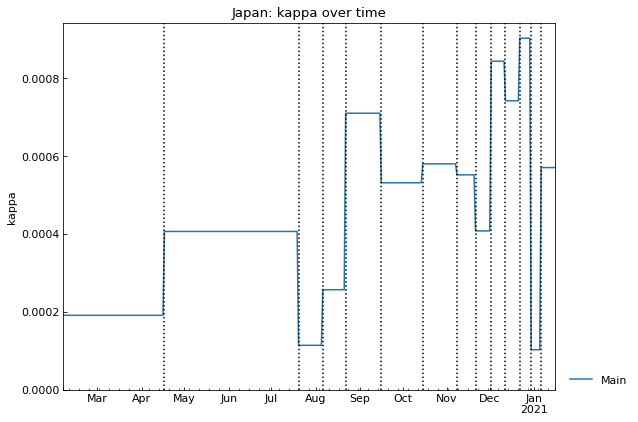

In [16]:
_ = snl.history(target="kappa")

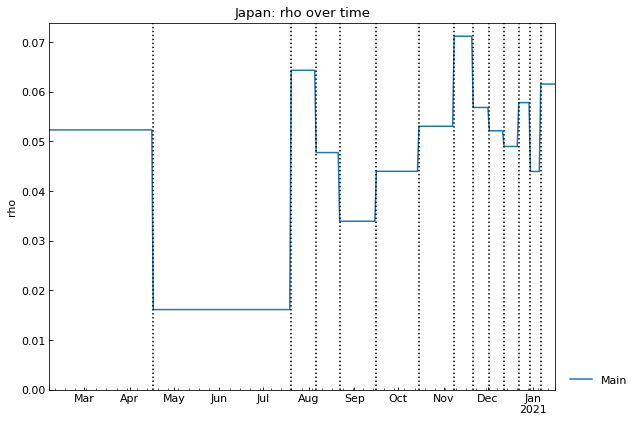

In [17]:
_ = snl.history(target="rho")

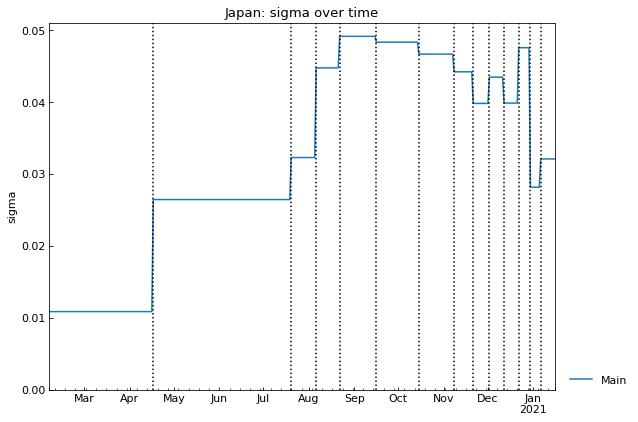

In [18]:
_ = snl.history(target="sigma")

Notes on the history of $\sigma$ value in japan (last updated: 28Dec2020):  
In Japan, we experienced two waves and we are in third wave. In the first wave (Apr - May), recovery period was too long because collapse of the medical care system occurred and no medicines were found.

Sigma values: the first wave < the second wave > the third wave

However, in the second wave (Jul - Oct), recovery period appears short because we have some effective medicines (not approved, in clinical study), yonger people (people un-associated to sever diseases) were infected.

In the third wave (Nov - ), older people tend to be infected and we are facing with medical collapse at this time...

### Show the history of reproduction number
$R_0$ ("R naught") means "the average number of secondary infections caused by an infected host" ([Infection Modeling — Part 1](https://towardsdatascience.com/infection-modeling-part-1-87e74645568a)). When this value is larger than 1, the infection disease is outbreaking.

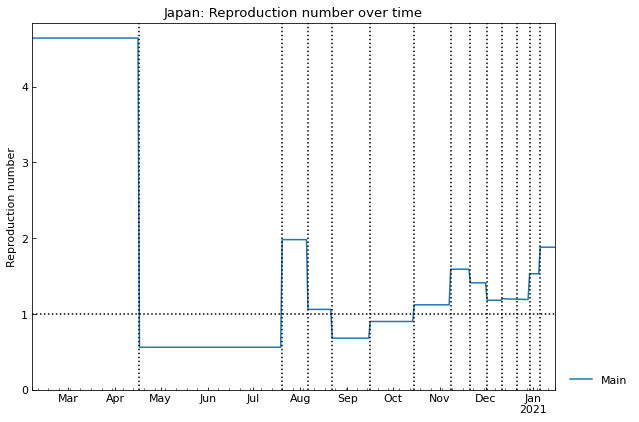

In [19]:
_ = snl.history(target="Rt")

### Simulate the number of cases
We can compare the actual and simulated (with estimated parameter values) number of confirmed/infected/recovered/fatal cases using `Scenario.history()` method.

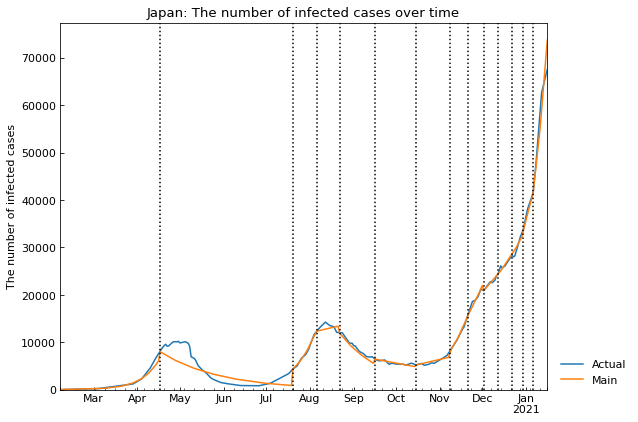

In [20]:
_ = snl.history("Infected")

### Main scenario
To investigate the effect of parameter changes, we will perform scenario analysis. In the main scenario, we will assume that the parameter values do not change after the last past phase.

i.e. If the parameter velues will not be changed until 01Apr2021, how many cases will be? We call this scenario as "Main" scenario.

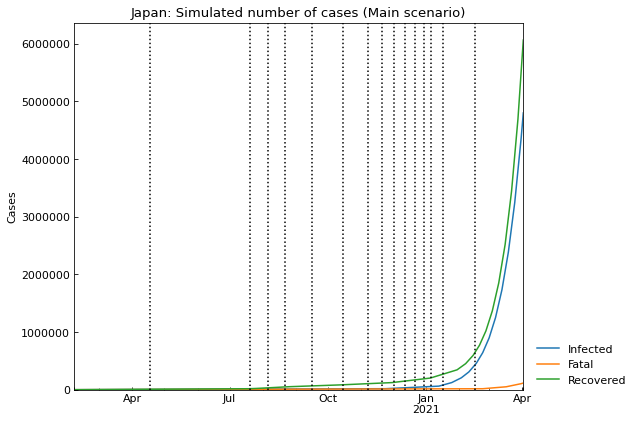

,Date,Confirmed,Fatal,Infected,Recovered
417,2021-03-29,8996375,94373,3960914,4941088
418,2021-03-30,9459284,99345,4158507,5201432
419,2021-03-31,9943193,104563,4363935,5474695
420,2021-04-01,10448721,110035,4577301,5761385
421,2021-04-02,10976486,115771,4798692,6062023


In [21]:
# Clear future phases in Main scenario
snl.clear(name="Main")
# Add one future phase 30 days with the parameter set of the last past phase
snl.add(days=30)
# Add one future phase until 01Apr2021 with the same parameter set
snl.add(end_date="01Apr2021", name="Main")
# Simulate the number of cases
snl.simulate(name="Main").tail()

### Medicine scenario
To investigate the effect of new medicines, we will assume that $\sigma$ will be changed in the future phases.

If $\sigma$ will be double in 30 days, how many cases will be? We will call this scenario as "Medicine" scenario.

In [22]:
# Calcuate the current sigma value of the last phase
sigma_current = snl.get("sigma", name="Main", phase="last")
sigma_current

0.03206982945373103

In [23]:
# Sigma value will be double
sigma_new = sigma_current * 2
sigma_new

0.06413965890746207

In [24]:
# Initialize "Medicine" scenario (with the same past phases as that of Main scenario)
snl.clear(name="Medicine")
# Add 30 days as a new future phases with the same parameter set
snl.add(name="Medicine", days=30, sigma=sigma_current)
# Add a phase until 01Apr2021 with doubled sigma value
snl.add(name="Medicine", end_date="01Apr2021", sigma=sigma_new)
snl.summary(name="Medicine")

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,1/alpha2 [day],1/beta [day],alpha1 [-],1/gamma [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,16Apr2020,126529100,SIR-F,4.64,0.019314,0.000191,0.052288,0.010854,720,2618,9,0.019,46,0.260938,3288.0,3 min 0 sec
1st,Past,17Apr2020,19Jul2020,126529100,SIR-F,0.56,0.071936,0.000406,0.016125,0.026429,720,1231,31,0.072,18,0.389551,3270.0,3 min 0 sec
2nd,Past,20Jul2020,05Aug2020,126529100,SIR-F,1.98,0.000590,0.000114,0.064282,0.032269,720,4389,7,0.001,15,0.021189,621.0,0 min 20 sec
3rd,Past,06Aug2020,21Aug2020,126529100,SIR-F,1.06,0.000483,0.000257,0.047723,0.044728,720,1948,10,0.000,11,0.039673,3434.0,3 min 0 sec
4th,Past,22Aug2020,15Sep2020,126529100,SIR-F,0.68,0.000350,0.000710,0.033912,0.049114,720,704,14,0.000,10,0.052936,328.0,0 min 10 sec
5th,Past,16Sep2020,14Oct2020,126529100,SIR-F,0.90,0.001151,0.000531,0.043952,0.048301,720,941,11,0.001,10,0.027704,340.0,0 min 10 sec
6th,Past,15Oct2020,07Nov2020,126529100,SIR-F,1.12,0.000250,0.000580,0.053020,0.046644,720,862,9,0.000,10,0.033157,3438.0,3 min 0 sec
7th,Past,08Nov2020,20Nov2020,126529100,SIR-F,1.59,0.000468,0.000551,0.071139,0.044182,720,906,7,0.000,11,0.012079,343.0,0 min 10 sec
8th,Past,21Nov2020,01Dec2020,126529100,SIR-F,1.41,0.000913,0.000408,0.056803,0.039791,720,1226,8,0.001,12,0.020991,3337.0,3 min 0 sec
9th,Past,02Dec2020,11Dec2020,126529100,SIR-F,1.18,0.000814,0.000843,0.052115,0.043444,720,593,9,0.001,11,0.008933,335.0,0 min 10 sec


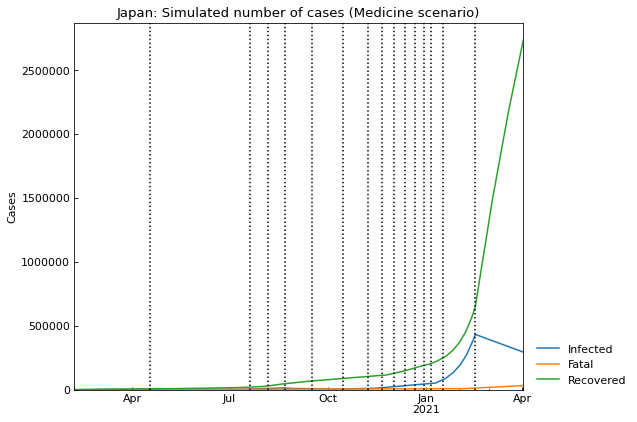

,Date,Confirmed,Fatal,Infected,Recovered
417,2021-03-29,2915419,30696,305257,2579466
418,2021-03-30,2951927,31070,302416,2618441
419,2021-03-31,2988085,31440,299592,2657053
420,2021-04-01,3023894,31807,296783,2695304
421,2021-04-02,3059356,32170,293990,2733196


In [25]:
# Simulate the number of cases
snl.simulate(name="Medicine").tail()

### Short-term prediction of parameter values
With OxCGRT data, we can predict the parameter values of the future phases because [OxCGRT indicators](https://github.com/OxCGRT/covid-policy-tracker) (policy measures) impact on parameter values with delay (=recovery period).  

OxCGRT indicators are

- school_closing,
- workplace_closing,
- cancel_events, 
- gatherings_restrictions,
- transport_closing,
- stay_home_restrictions,
- internal_movement_restrictions,
- international_movement_restrictions,
- information_campaigns,
- testing_policy, and
- contact_tracing.

In [26]:
# Fitting with linear regression model (Elastic Net regression)
fit_dict = snl.fit(oxcgrt_data=oxcgrt_data, name="Forecast")
print(f"Determination coefficient: {fit_dict['score_train']} (train)")
print(f"Determination coefficient: {fit_dict['score_test']} (test)")
print("Intercept:")
fit_dict["intercept"].style.background_gradient(axis=None)

Determination coefficient: 0.6932904542353823 (train)
Determination coefficient: 0.7008438392536016 (test)
Intercept:


,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing
theta,0.009525,0.019978,-0.021498,0.000000,0.006848,0.036929,0.019978,0.007834,-0.004847,-0.073713,0.057759
kappa,-0.000065,0.000026,-0.000039,0.000000,-0.000282,0.000231,0.000026,-0.000084,0.000066,0.000049,0.000391
rho,-0.003018,-0.012566,0.013748,0.000000,0.000541,-0.027258,-0.012566,-0.002954,0.001543,0.036085,-0.027779
sigma,-0.006912,0.002963,-0.003761,0.000000,-0.006658,0.015810,0.002963,-0.003827,0.003088,0.018596,-0.015656


In [27]:
# Short-term prediction
snl.predict(name="Forecast").summary(name="Forecast")

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,1/alpha2 [day],1/beta [day],alpha1 [-],1/gamma [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,16Apr2020,126529100,SIR-F,4.64,0.019314,0.000191,0.052288,0.010854,720,2618,9,0.019,46,0.260938,3288.0,3 min 0 sec
1st,Past,17Apr2020,19Jul2020,126529100,SIR-F,0.56,0.071936,0.000406,0.016125,0.026429,720,1231,31,0.072,18,0.389551,3270.0,3 min 0 sec
2nd,Past,20Jul2020,05Aug2020,126529100,SIR-F,1.98,0.000590,0.000114,0.064282,0.032269,720,4389,7,0.001,15,0.021189,621.0,0 min 20 sec
3rd,Past,06Aug2020,21Aug2020,126529100,SIR-F,1.06,0.000483,0.000257,0.047723,0.044728,720,1948,10,0.000,11,0.039673,3434.0,3 min 0 sec
4th,Past,22Aug2020,15Sep2020,126529100,SIR-F,0.68,0.000350,0.000710,0.033912,0.049114,720,704,14,0.000,10,0.052936,328.0,0 min 10 sec
5th,Past,16Sep2020,14Oct2020,126529100,SIR-F,0.90,0.001151,0.000531,0.043952,0.048301,720,941,11,0.001,10,0.027704,340.0,0 min 10 sec
6th,Past,15Oct2020,07Nov2020,126529100,SIR-F,1.12,0.000250,0.000580,0.053020,0.046644,720,862,9,0.000,10,0.033157,3438.0,3 min 0 sec
7th,Past,08Nov2020,20Nov2020,126529100,SIR-F,1.59,0.000468,0.000551,0.071139,0.044182,720,906,7,0.000,11,0.012079,343.0,0 min 10 sec
8th,Past,21Nov2020,01Dec2020,126529100,SIR-F,1.41,0.000913,0.000408,0.056803,0.039791,720,1226,8,0.001,12,0.020991,3337.0,3 min 0 sec
9th,Past,02Dec2020,11Dec2020,126529100,SIR-F,1.18,0.000814,0.000843,0.052115,0.043444,720,593,9,0.001,11,0.008933,335.0,0 min 10 sec


In [28]:
# Or, when you do not need 'fit_dict'
# snl.fit_predict(oxcgrt_data=oxcgrt_data, name="Forecast").summary(name="Forecast")

### Compare the scenarios
We will compare the scenarios with representative values, reproduction number and parameter values. Currently, we can compare the scenarios with the following indexes.

- max(Infected): max value of Infected
- argmax(Infected): the date when Infected shows max value
- Infected on …: Infected on the end date of the last phase
- Fatal on …: Fatal on the end date of the last phase

In [29]:
snl.describe()

,max(Infected),argmax(Infected),Confirmed on 02Apr2021,Infected on 02Apr2021,Fatal on 02Apr2021,Confirmed on 03Feb2021,Infected on 03Feb2021,Fatal on 03Feb2021,14th_Rt,15th_Rt
Main,4798692,02Apr2021,10976486.0,4798692.0,115771.0,NaN,NaN,NaN,1.88,1.88
Medicine,432516,16Feb2021,3059356.0,293990.0,32170.0,NaN,NaN,NaN,1.88,0.95
Forecast,140191,03Feb2021,NaN,NaN,NaN,517230.0,140191.0,8209.0,1.51,-


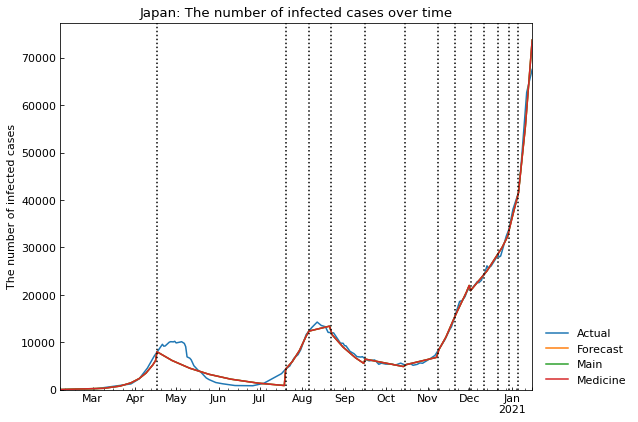

In [30]:
_ = snl.history(target="Infected")

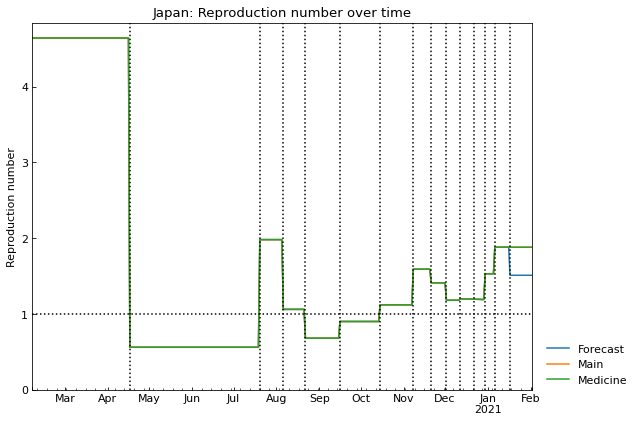

In [31]:
_ = snl.history(target="Rt")

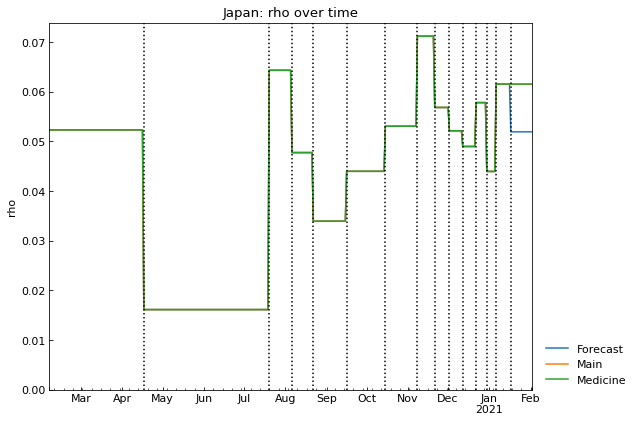

In [32]:
_ = snl.history(target="rho")

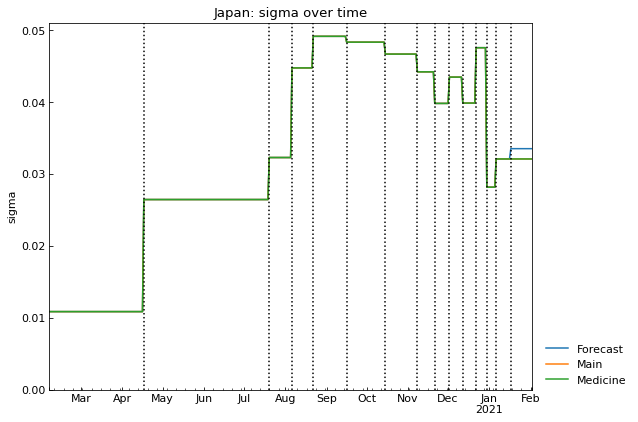

In [33]:
_ = snl.history(target="sigma")

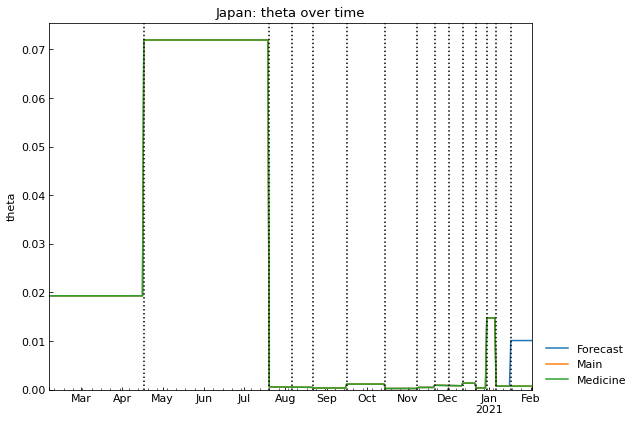

In [34]:
_ = snl.history(target="theta")

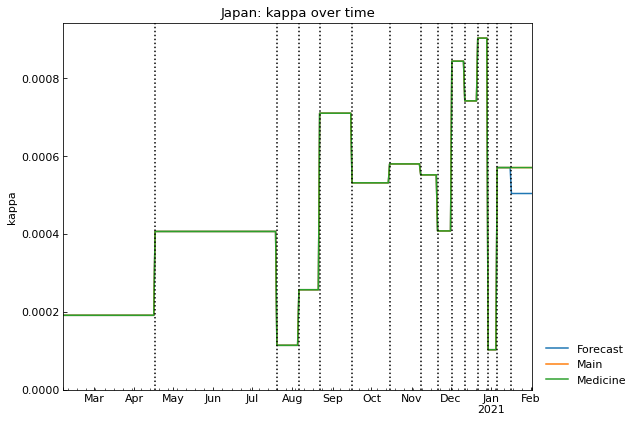

In [35]:
_ = snl.history(target="kappa")

### Change rate of parameters in main scenario
History of each parameter will be shown. Values will be divided by the values in 0th phase.

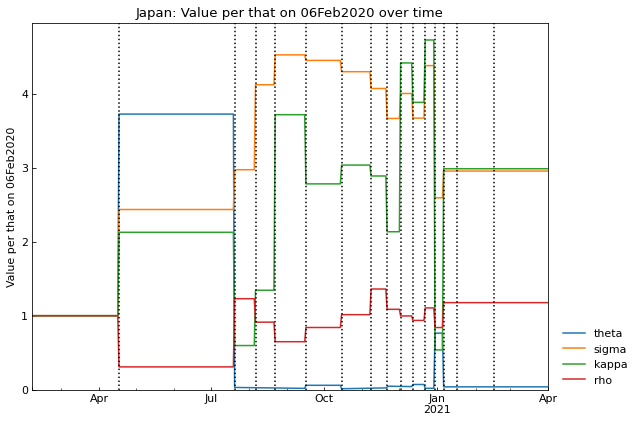

In [36]:
_ = snl.history_rate(name="Main")

## Retrospective analysis
We can evaluate the impact of measures using past records. How many people were infected if the parameter values have not changed sinse 01Sep2020?

In [37]:
# Perform retrospective analysis
snl_retro = cs.Scenario(jhu_data, population_data, "Japan")
snl_retro.retrospective("01Sep2020", model=cs.SIRF, control="Main", target="Retrospective")


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	12th phase (30Dec2020 - 05Jan2021): finished  319 trials in 0 min 10 sec


	 6th phase (16Sep2020 - 14Oct2020): finished  332 trials in 0 min 10 sec

	 0th phase (08Nov2020 - 20Nov2020): finished  332 trials in 0 min 10 sec

	 8th phase (12Dec2020 - 21Dec2020): finished  327 trials in 0 min 10 sec

	 3rd phase (22Dec2020 - 29Dec2020): finished  837 trials in 0 min 30 sec

	 4th phase (20Jul2020 - 05Aug2020): finished  599 trials in 0 min 20 sec

	 9th phase (22Aug2020 - 31Aug2020): finished  331 trials in 0 min 10 sec

	10th phase (02Dec2020 - 11Dec2020): finished  330 trials in 0 min 10 sec

	11th phase (21Nov2020 - 01Dec2020): finished 3075 trials in 3 min  0 sec

	 2nd phase (06Feb2020 - 16Apr2020): finished 3028 trials in 3 min  0 sec

	 7th phase (17Apr2020 - 19Jul2020): finished 2991 trials in 3 min  0 sec

	 5th phase (01Sep2020 - 15Sep2020): finished  321 trials in 0 min 10 sec

	13th phase (06Jan2021 - 16Jan2021): finished 3081 trials in 3 min  0 sec

	 1st phase (06Aug2020 - 21Aug2020): finished 3219 trials in 3 min  0 sec

	14th phase (15Oct2020 - 07Nov2020): finished 3237 trials in 3 min  0 sec

Completed optimization. Total: 6 min 33 sec



<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	 1st phase (01Sep2020 - 16Jan2021): finished 9967 trials in 3 min  0 sec

Completed optimization. Total: 3 min  1 sec


In [38]:
# Show the summary of estimation
cols = ["Start", "End", "ODE", "Rt", *cs.SIRF.PARAMETERS] + ["RMSLE", "Trials", "Runtime"]
snl_retro.summary(columns=cols)

Start        End    ODE    Rt     theta     kappa  \
Scenario      Phase                                                          
Main          0th    06Feb2020  16Apr2020  SIR-F  4.64  0.019314  0.000191   
              1st    17Apr2020  19Jul2020  SIR-F  0.56  0.071936  0.000406   
              2nd    20Jul2020  05Aug2020  SIR-F  1.99  0.000742  0.000158   
              3rd    06Aug2020  21Aug2020  SIR-F  1.06  0.000483  0.000257   
              4th    22Aug2020  31Aug2020  SIR-F  0.74  0.000472  0.000552   
              5th    01Sep2020  15Sep2020  SIR-F  0.73  0.001361  0.000739   
              6th    16Sep2020  14Oct2020  SIR-F  0.90  0.001151  0.000531   
              7th    15Oct2020  07Nov2020  SIR-F  1.12  0.000911  0.000544   
              8th    08Nov2020  20Nov2020  SIR-F  1.59  0.000468  0.000551   
              9th    21Nov2020  01Dec2020  SIR-F  1.41  0.000913  0.000408   
              10th   02Dec2020  11Dec2020  SIR-F  1.18  0.000814  0.000843   
              11th   12Dec2020  21Dec2020  SIR-F  1.20  0.001362  0.000741   
              12th   22Dec2020  29Dec2020  SIR-F  1.19  0.000369  0.000902   
              13th   30Dec2020  05Jan2021  SIR-F  1.53  0.014763  0.000103   
              14th   06Jan2021  16Jan2021  SIR-F  1.88  0.000744  0.000570   
Retrospective 0th    06Feb2020  16Apr2020  SIR-F  4.64  0.019314  0.000191   
              1st    17Apr2020  19Jul2020  SIR-F  0.56  0.071936  0.000406   
              2nd    20Jul2020  05Aug2020  SIR-F  1.99  0.000742  0.000158   
              3rd    06Aug2020  21Aug2020  SIR-F  1.06  0.000483  0.000257   
              4th    22Aug2020  31Aug2020  SIR-F  0.74  0.000472  0.000552   
              5th    01Sep2020  16Jan2021  SIR-F  0.74  0.000472  0.000552   

                          rho     sigma     RMSLE  Trials       Runtime  
Scenario      Phase                                                      
Main          0th    0.052288  0.010854  0.260938    3028  3 min  0 sec  
              1st    0.016125  0.026429  0.389551    2991  3 min  0 sec  
              2nd    0.064269  0.032194  0.021638     599  0 min 20 sec  
              3rd    0.047723  0.044728  0.039673    3219  3 min  0 sec  
              4th    0.035336  0.046952  0.015091     331  0 min 10 sec  
              5th    0.034480  0.046713  0.017227     321  0 min 10 sec  
              6th    0.043952  0.048301  0.027704     332  0 min 10 sec  
              7th    0.052749  0.046409  0.033158    3237  3 min  0 sec  
              8th    0.071139  0.044182  0.012079     332  0 min 10 sec  
              9th    0.056803  0.039791  0.020991    3075  3 min  0 sec  
              10th   0.052115  0.043444  0.008933     330  0 min 10 sec  
              11th   0.048952  0.039836  0.010940     327  0 min 10 sec  
              12th   0.057779  0.047534  0.014704     837  0 min 30 sec  
              13th   0.043927  0.028149  0.013032     319  0 min 10 sec  
              14th   0.061506  0.032070  0.030386    3081  3 min  0 sec  
Retrospective 0th    0.052288  0.010854  0.260938    3028  3 min  0 sec  
              1st    0.016125  0.026429  0.389551    2991  3 min  0 sec  
              2nd    0.064269  0.032194  0.021638     599  0 min 20 sec  
              3rd    0.047723  0.044728  0.039673    3219  3 min  0 sec  
              4th    0.035336  0.046952  0.015091     331  0 min 10 sec  
              5th    0.035336  0.046952  1.539598    9967  3 min  0 sec

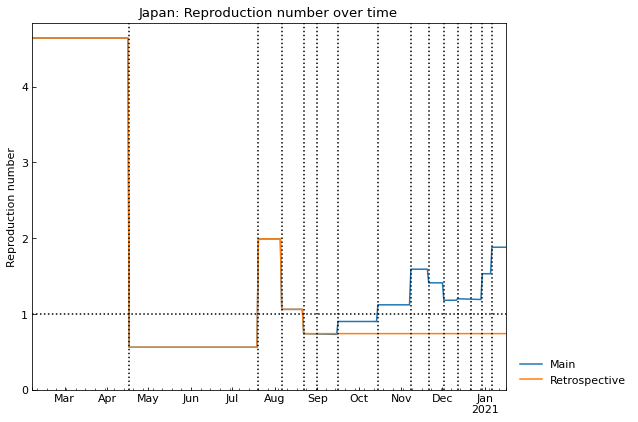

In [39]:
# History of reproduction number
_ = snl_retro.history("Rt")

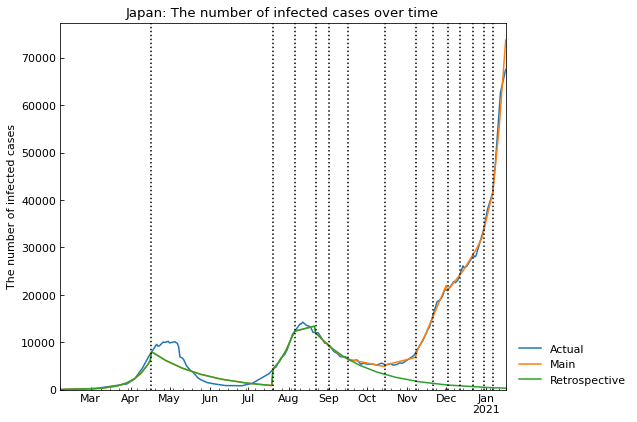

In [40]:
# History of Infected
_ = snl_retro.history("Infected")

In [41]:
# Show the representative values
snl_retro.describe()

,max(Infected),argmax(Infected),Confirmed on 17Jan2021,Infected on 17Jan2021,Fatal on 17Jan2021,5th_Rt,6th_Rt,7th_Rt,8th_Rt,9th_Rt,10th_Rt,11th_Rt,12th_Rt,13th_Rt,14th_Rt
Main,78108,17Jan2021,330522,78108,4504,0.73,0.9,1.12,1.59,1.41,1.18,1.2,1.19,1.53,1.88
Retrospective,13401,21Aug2020,94291,320,1713,0.74,-,-,-,-,-,-,-,-,-
